## Lesson 1: Introduction and motivation

See [slides](https://docs.google.com/presentation/d/1O5v1qFMQEe430aynnaq-4gR0cMvqSsYfsaHJ4RoHpoE/edit#slide=id.g2ee3908cf2f_0_0)

## Lesson 2: The Simplest Graph

Let's build a simple 3 step graph:

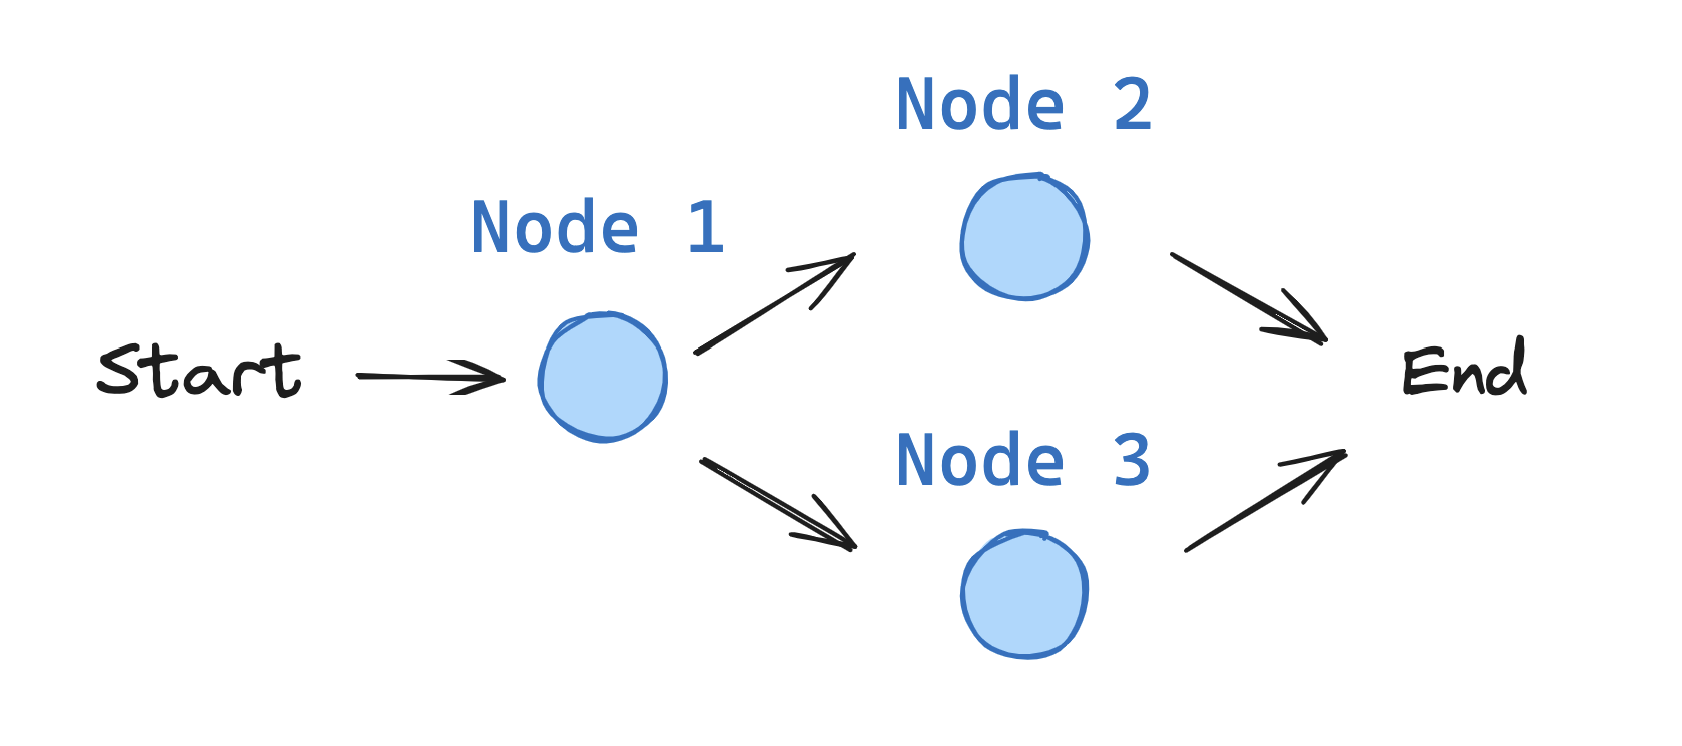

In [22]:
%%capture --no-stderr
%pip install --quiet -U langgraph

### Graph Definition

`State`

The first thing you do when you define a graph is define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph. 

The State schema serves as the input schema for all Nodes and Edges in the graph.

This example uses a simple dictionary structure with a single key `graph_state` of type str.

In [83]:
from typing import TypedDict

class State(TypedDict):
    graph_state: str

`Nodes`

[Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are just python functions.

The first positional argument is the state, as defined above.

Each node operates on the state.

By default, each node [will also override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior state value.

In [89]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

`Edges` 

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) simply connect the nodes.

Normal Edges are used if you want to always go from, for example, `node_1` to `node_2`.

[Conditional Edges](https://langchain-ai.github.io/langgraph/reference/graphs/?h=conditional+edge#langgraph.graph.StateGraph.add_conditional_edges) are used want to optionally route between nodes.

The conditional edge is implemented as a function that returns the next node to visit based upon some logic.

In [90]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    
    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state'] 
    
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

`Graph Construction`

Now, we build the graph from our [components](
https://langchain-ai.github.io/langgraph/concepts/low_level/)!

The [StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is the main graph class to use.

First, we initialize a StateGraph with the `State` class we defined above.

Then, we add our nodes and edges.

We use the `START` Node, a special node that sends user input to the graph, to indicate where to start our graph.

The `END` Node is a special node that represents a terminal node. 

Compiling is a simple step that performs a few basic checks on the structure of your graph (no orphaned nodes, etc). 

We can visualize the graph as a Mermaid diagram.

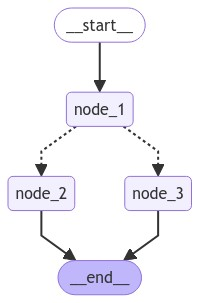

In [94]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

### Graph Invocation

The compiled graph implements the [runnable](https://python.langchain.com/v0.1/docs/expression_language/interface/) protocol.

This provides a standard way to execute LangChain components. 
 
`invoke` is one of the standard methods in this interface.

`Input`
 
The input is a dictionary `{"graph_state": "Hi, this is lance."`}, which sets the initial value for our graph state dict.

`Execution Process:`
 
When `invoke` is called, the graph starts execution from the `START` node.

It progresses through the defined nodes (`node_1`, `node_2`, `node_3`) in order.

The conditional edge will traverse from node `1` to node `2` or `3` using a 50/50 decision rule. 

Each node function receives the current state and overrides it.

The execution continues until it reaches the `END` node.

`Synchronous Operation:`
 
`invoke` runs the entire graph synchronously.

This waits for each step to complete before moving to the next.

It returns the final state of the graph after all nodes have executed.

In this case, it would return the state after `node_3` has completed.

In [97]:
graph.invoke({"graph_state" : "Hi, this is Lance."})

---Node 1---
---Node 2---


{'graph_state': 'Hi, this is Lance. I am happy!'}

## Lesson 3: LangGraph Studio

We've [released an IDE called LangGraph Studio](https://blog.langchain.dev/langgraph-studio-the-first-agent-ide/), which broadly supports agentic workflows! 

You can download it [here](https://github.com/langchain-ai/langgraph-studio?tab=readme-ov-file#download) and setup a LangSmith account.

When done, simply load the `assistant` folder in this repo.

We can then select and visualize the above grade as `simplest_graph` (top right).

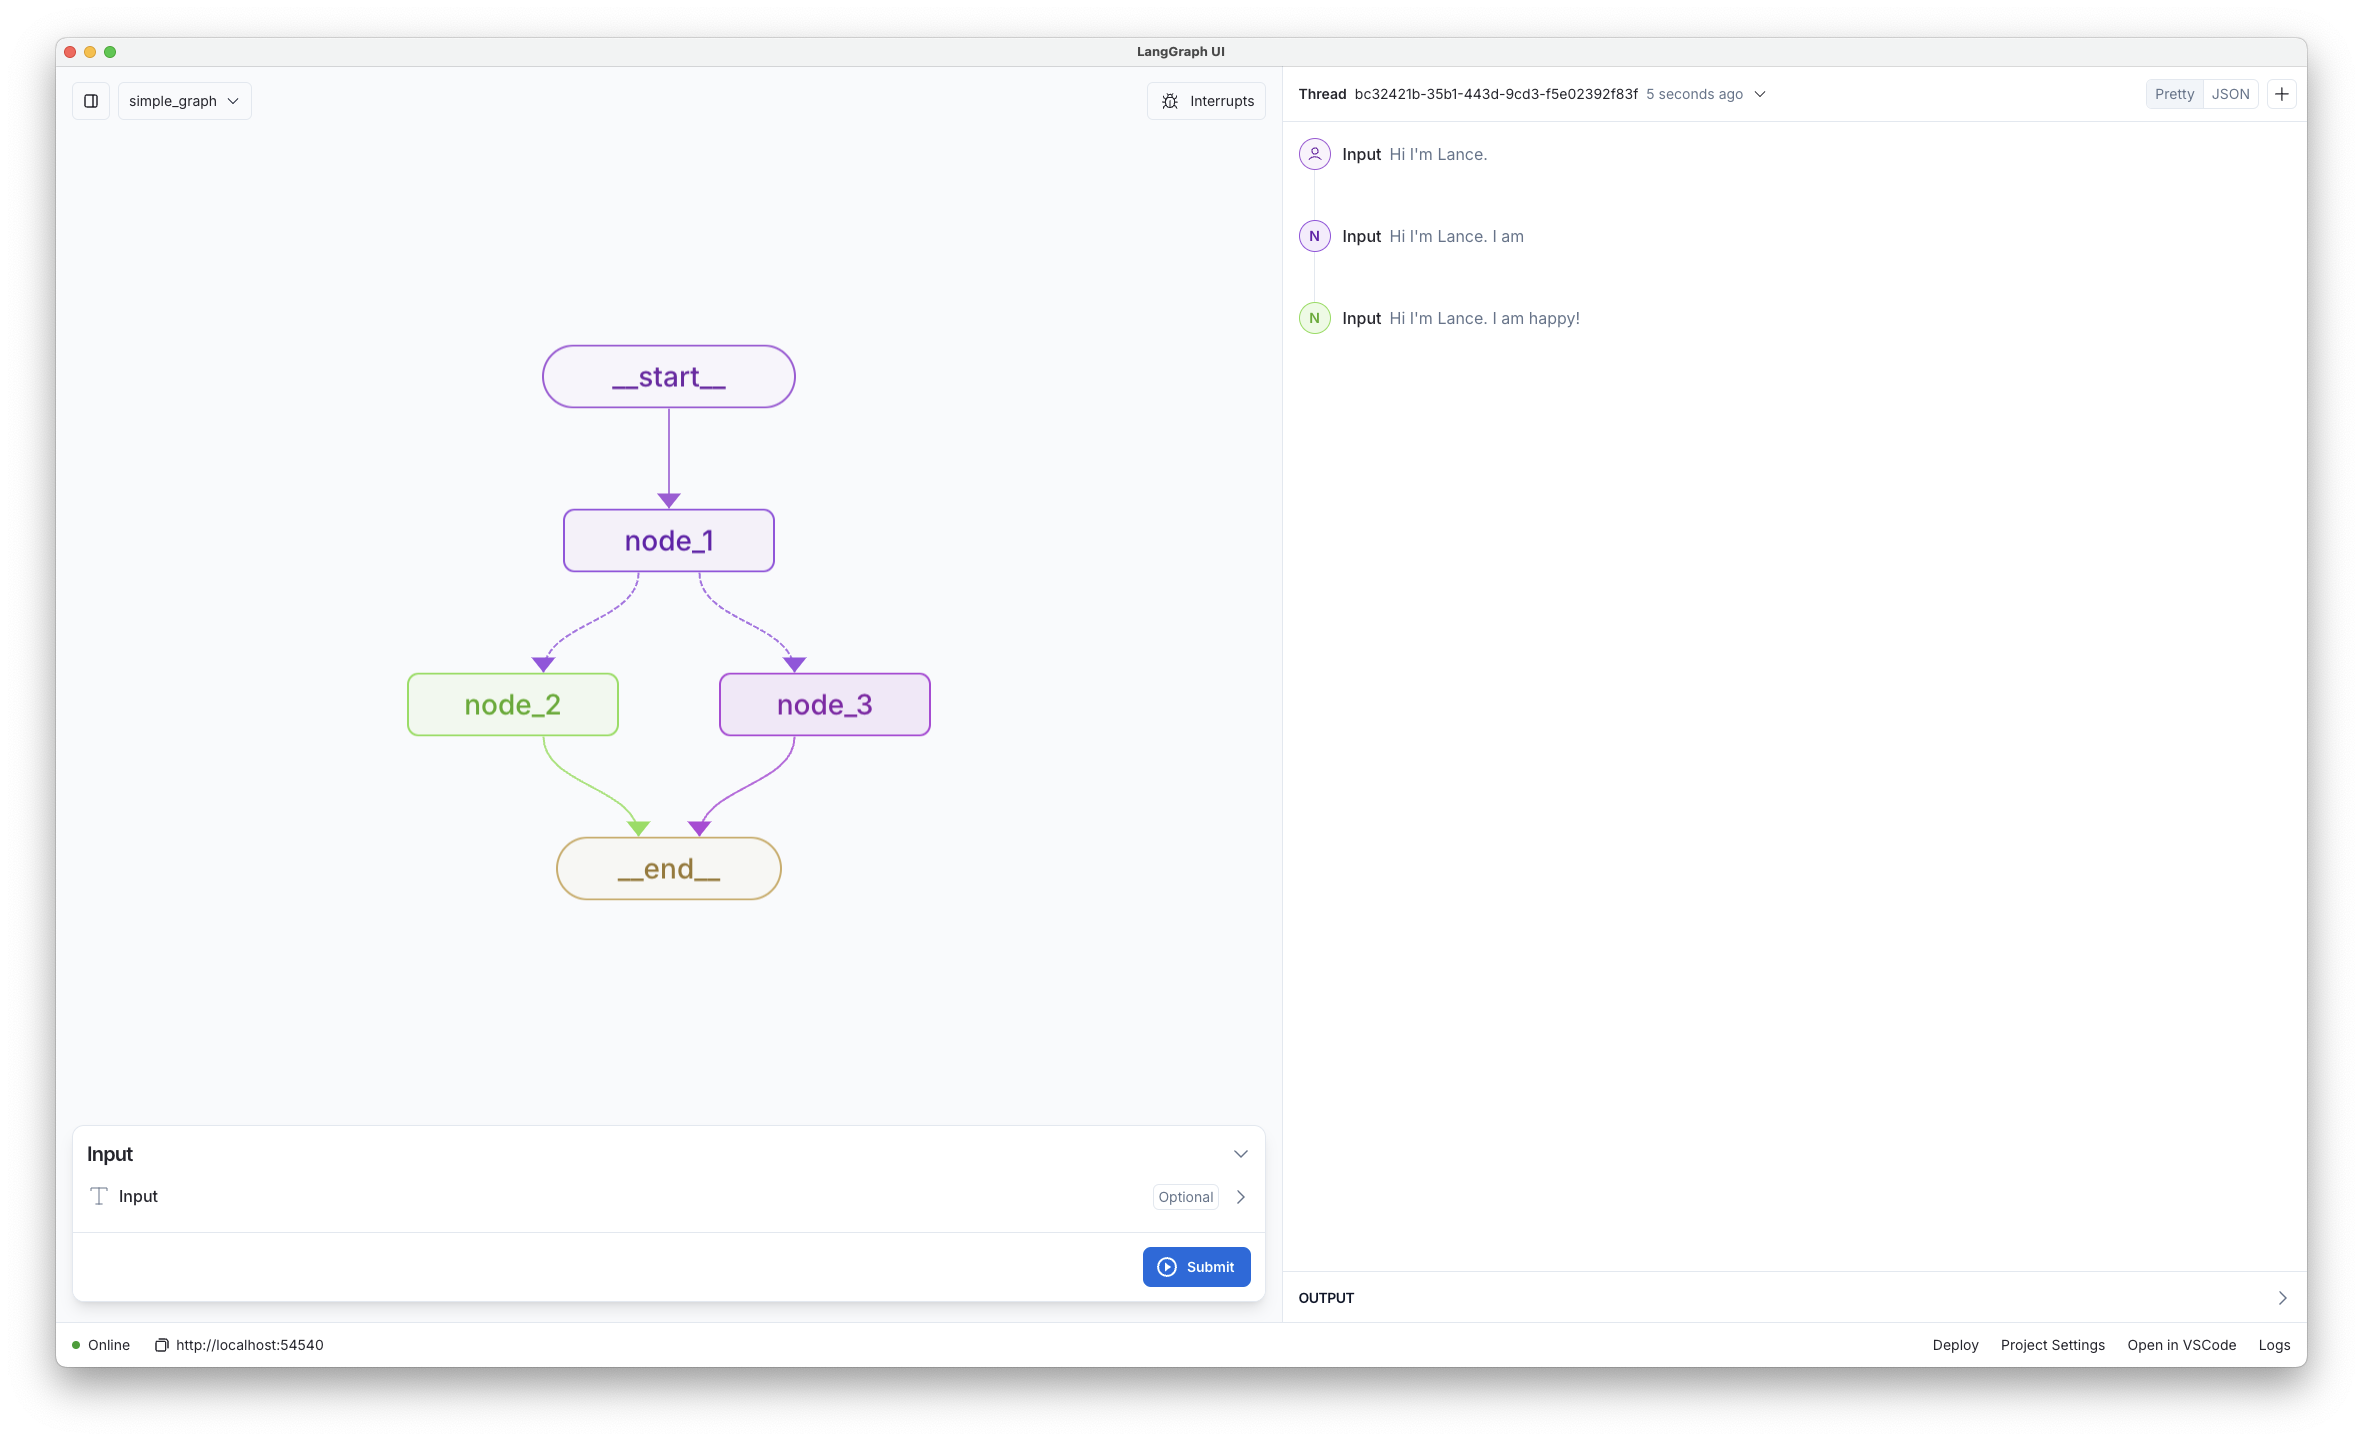

We'll be incorporating LangGraph studio into the following lessons!

## Lesson 4: LLM Chain

Now, let's build up to a simple chain that combines 4 key [concepts](https://python.langchain.com/v0.2/docs/concepts/):

1) Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph
2) Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models)
3) [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our LLM
4) [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in our graph 

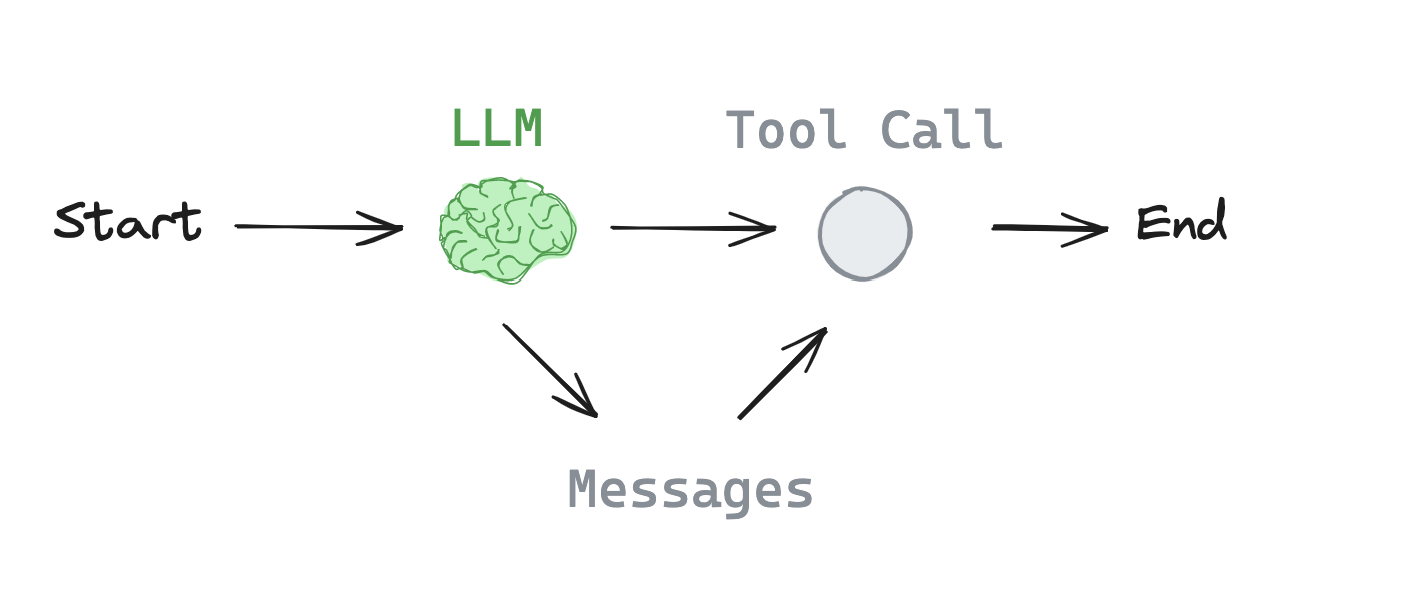

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core

### Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation. 

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call. 

Let's create a list of messages. Each message can be supplied with a few things:

* `content` - content of the messsage
* `name` - optionally, who is creating the message
* `response_metadata` - optionally, a dict of metadata that is often specific to each model provider

In [98]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.extend([HumanMessage(content=f"Yes, that's right.",name="Lance")])
messages.extend([AIMessage(content=f"Great, what would you like to learn about.", name="Model")])
messages.extend([HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance")])

We can view them easily using pprint, which will print the message contnet. 

In [100]:
from pprint import pprint
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [16]:
m.content, m.role

('I want to learn about the best place to see Orcas in the US.', 'Lance')

### Chat Models

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) can use a sequence of message as input and support message roles, as discussed above.

Here, ensure your `OPENAI_API_KEY` is set:

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We can load a chat model and invoke it with out list of messages.

In [101]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)

We can see that the result is an `AIMessage`.

In [102]:
type(result)

langchain_core.messages.ai.AIMessage

We can see the `content` of the message.

In [104]:
messages

[AIMessage(content='So you said you were researching ocean mammals?', name='Model'),
 HumanMessage(content="Yes, that's right.", name='Lance'),
 AIMessage(content='Great, what would you like to learn about.', name='Model'),
 HumanMessage(content='I want to learn about the best place to see Orcas in the US.', name='Lance')]

No specific `role` is assigned by the chat model.

But we do have `response_metadata` from the model provider.

In [105]:
result.response_metadata

{'token_usage': {'completion_tokens': 321,
  'prompt_tokens': 67,
  'total_tokens': 388},
 'model_name': 'gpt-4o-2024-05-13',
 'system_fingerprint': 'fp_3aa7262c27',
 'finish_reason': 'stop',
 'logprobs': None}

### Binding tools

Tools are needed whenever you want a model to control parts of your code or call out to external APIs.

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/).

The [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 

You can pass any Python function into `ChatModel.bind_tools()`.

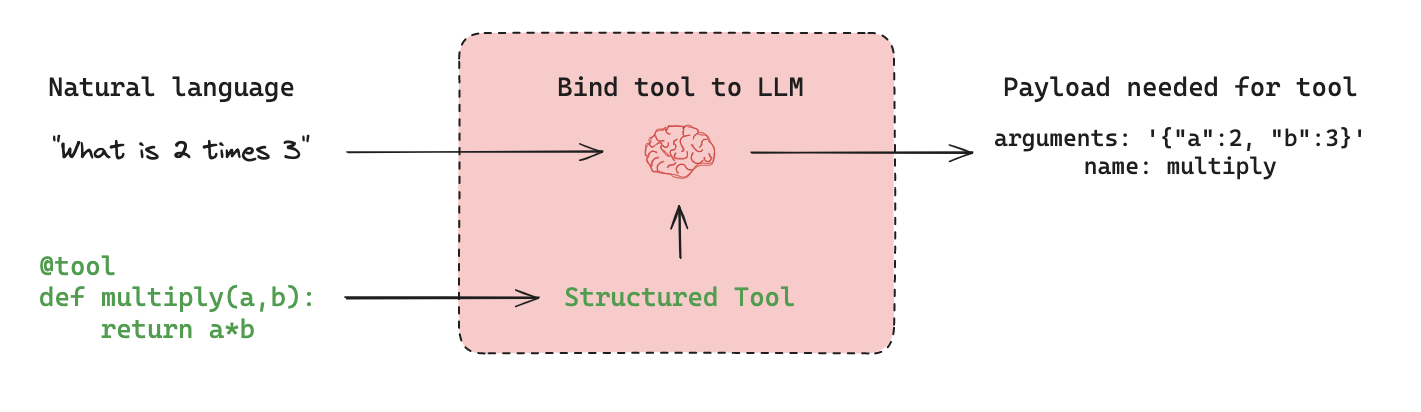

In [106]:
# This will be a tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# LLM with bound tool
llm_with_tools = llm.bind_tools([multiply])

### Using messages and chat models in our graph

#### Type

With these foundations in place, we can now dicuss how to use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state `MessagesState`. 

It's defined as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of type `AnyMessage`, meaning it's a list of messages.

Now, we have a minor problem: as our graph runs, we want to append messages to to our `messages` state key.

In order to do this, we need to introduce the concept of reducers.

#### Reducer

[Reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) allow us to specify how state updates are perfomred.

If no reducer function is explicitly specified, then it is assumed that all updates to that key should *override it*.

Since we want to append messages, we can speciify a reducer: we'll use the pre-built `add_messages` reducer!

This ensures that state updates you send to the graph are appended to the existing list of messages.

We use`Annotated` to associate our reducer function as metadata to our key.

In [31]:
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in your state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)! 

`MessagesState` is defined: 

* With a pre-build single `messages` key
* Which is a list of `AnyMessage` objects and uses the `add_messages` reducer

In [33]:
from langgraph.graph import MessagesState

class State(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

The `MessagesState` and `State` both work equivalently!

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [107]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

Let's see this working!

In [108]:
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', name='Model', id='aa3473ef-ae09-41b8-b197-d3792cbe4cd6'),
 HumanMessage(content="I'm looking for information on marine biology.", name='Lance', id='c119fe61-1113-4895-bee4-542092034769'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', name='Model', id='e1bfba16-8f59-4d8a-b492-39875eaf6bfd')]

#### Using this with our graph

Now, let use `MessagesState` with a graph.

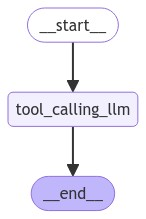

In [109]:
# State
class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build grapph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Here, the LLM responds normally without any tool calls.

In [110]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
messages['messages'][-1]

AIMessage(content='Hi there! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 54, 'total_tokens': 65}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'stop', 'logprobs': None}, id='run-c466470e-aaf2-43e8-85e0-981d8c4345e4-0', usage_metadata={'input_tokens': 54, 'output_tokens': 11, 'total_tokens': 65})

In [112]:
messages['messages']

[HumanMessage(content='Hello!', id='80e8bc63-b9e1-4137-9e3e-91478a703151'),
 AIMessage(content='Hi there! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 54, 'total_tokens': 65}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'stop', 'logprobs': None}, id='run-c466470e-aaf2-43e8-85e0-981d8c4345e4-0', usage_metadata={'input_tokens': 54, 'output_tokens': 11, 'total_tokens': 65})]

Now, we can see that a tool call is performed if our input related to the tool!

In [117]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3!")})
messages['messages'][-1].tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_1EfDj69kN0Mj4efcBV7TcEXj',
  'type': 'tool_call'}]

In [118]:
messages

{'messages': [HumanMessage(content='Multiply 2 and 3!', id='30ba1159-a10e-4a0d-9cec-4ffe7f96893b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1EfDj69kN0Mj4efcBV7TcEXj', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 59, 'total_tokens': 76}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ec70ebc1-2e79-4b70-9235-9ac2d3c48303-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_1EfDj69kN0Mj4efcBV7TcEXj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 59, 'output_tokens': 17, 'total_tokens': 76})]}

#### Conditional edge

Now, we can see that our chat model either:

* Returns a tool call
* Returns a natural langage response

We can easily have our graph work with either output! 

For this, we can use two ideas:

(1) A node that will call our tool 

(2) A conditional edge that will route to our tool calling node or simply end if no tool call is performed 

For (1) we use the [built-in `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools.

For (2) we use the [built-in `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition).

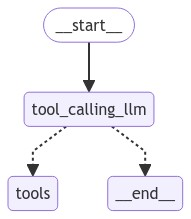

In [119]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [121]:
messages = graph.invoke({"messages": ("user", "Multiply 3 and 2")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 3 and 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_M0vcm8Y3MFnLJFCvIWtLhLR8)
 Call ID: call_M0vcm8Y3MFnLJFCvIWtLhLR8
  Args:
    a: 3
    b: 2
================================= Tool Message =================================
Name: multiply

6


Now, we can see that the graph runs the tool!

It responds with a `ToolMessage`. 

In [8]:
messages = graph.invoke({"messages": ("user", "Multiply 3 and 2")})
messages['messages'][-1]

ToolMessage(content='6', name='multiply', id='a1747017-2083-42ea-a3ed-e66539ddb1b2', tool_call_id='call_fiQpCK6A87dbygZTZo4EEtAA')

Here, we can also introduce [LangGraph Studio](https://github.com/langchain-ai/langgraph-studio?tab=readme-ov-file).

This is free to anyone with a LangSmith account.

It offers an agent IDE that enables visualization, interaction, and debugging of complex agentic applications. 

Follow the `README` [here](https://github.com/langchain-ai/langgraph-studio?tab=readme-ov-file) to set up LangGraph Studio.

Load the above graph with `chain.py`. 

We can interact with our loaded graph, as shown above. 

We'll explore more advanced usage of studio in future lessons and modules!

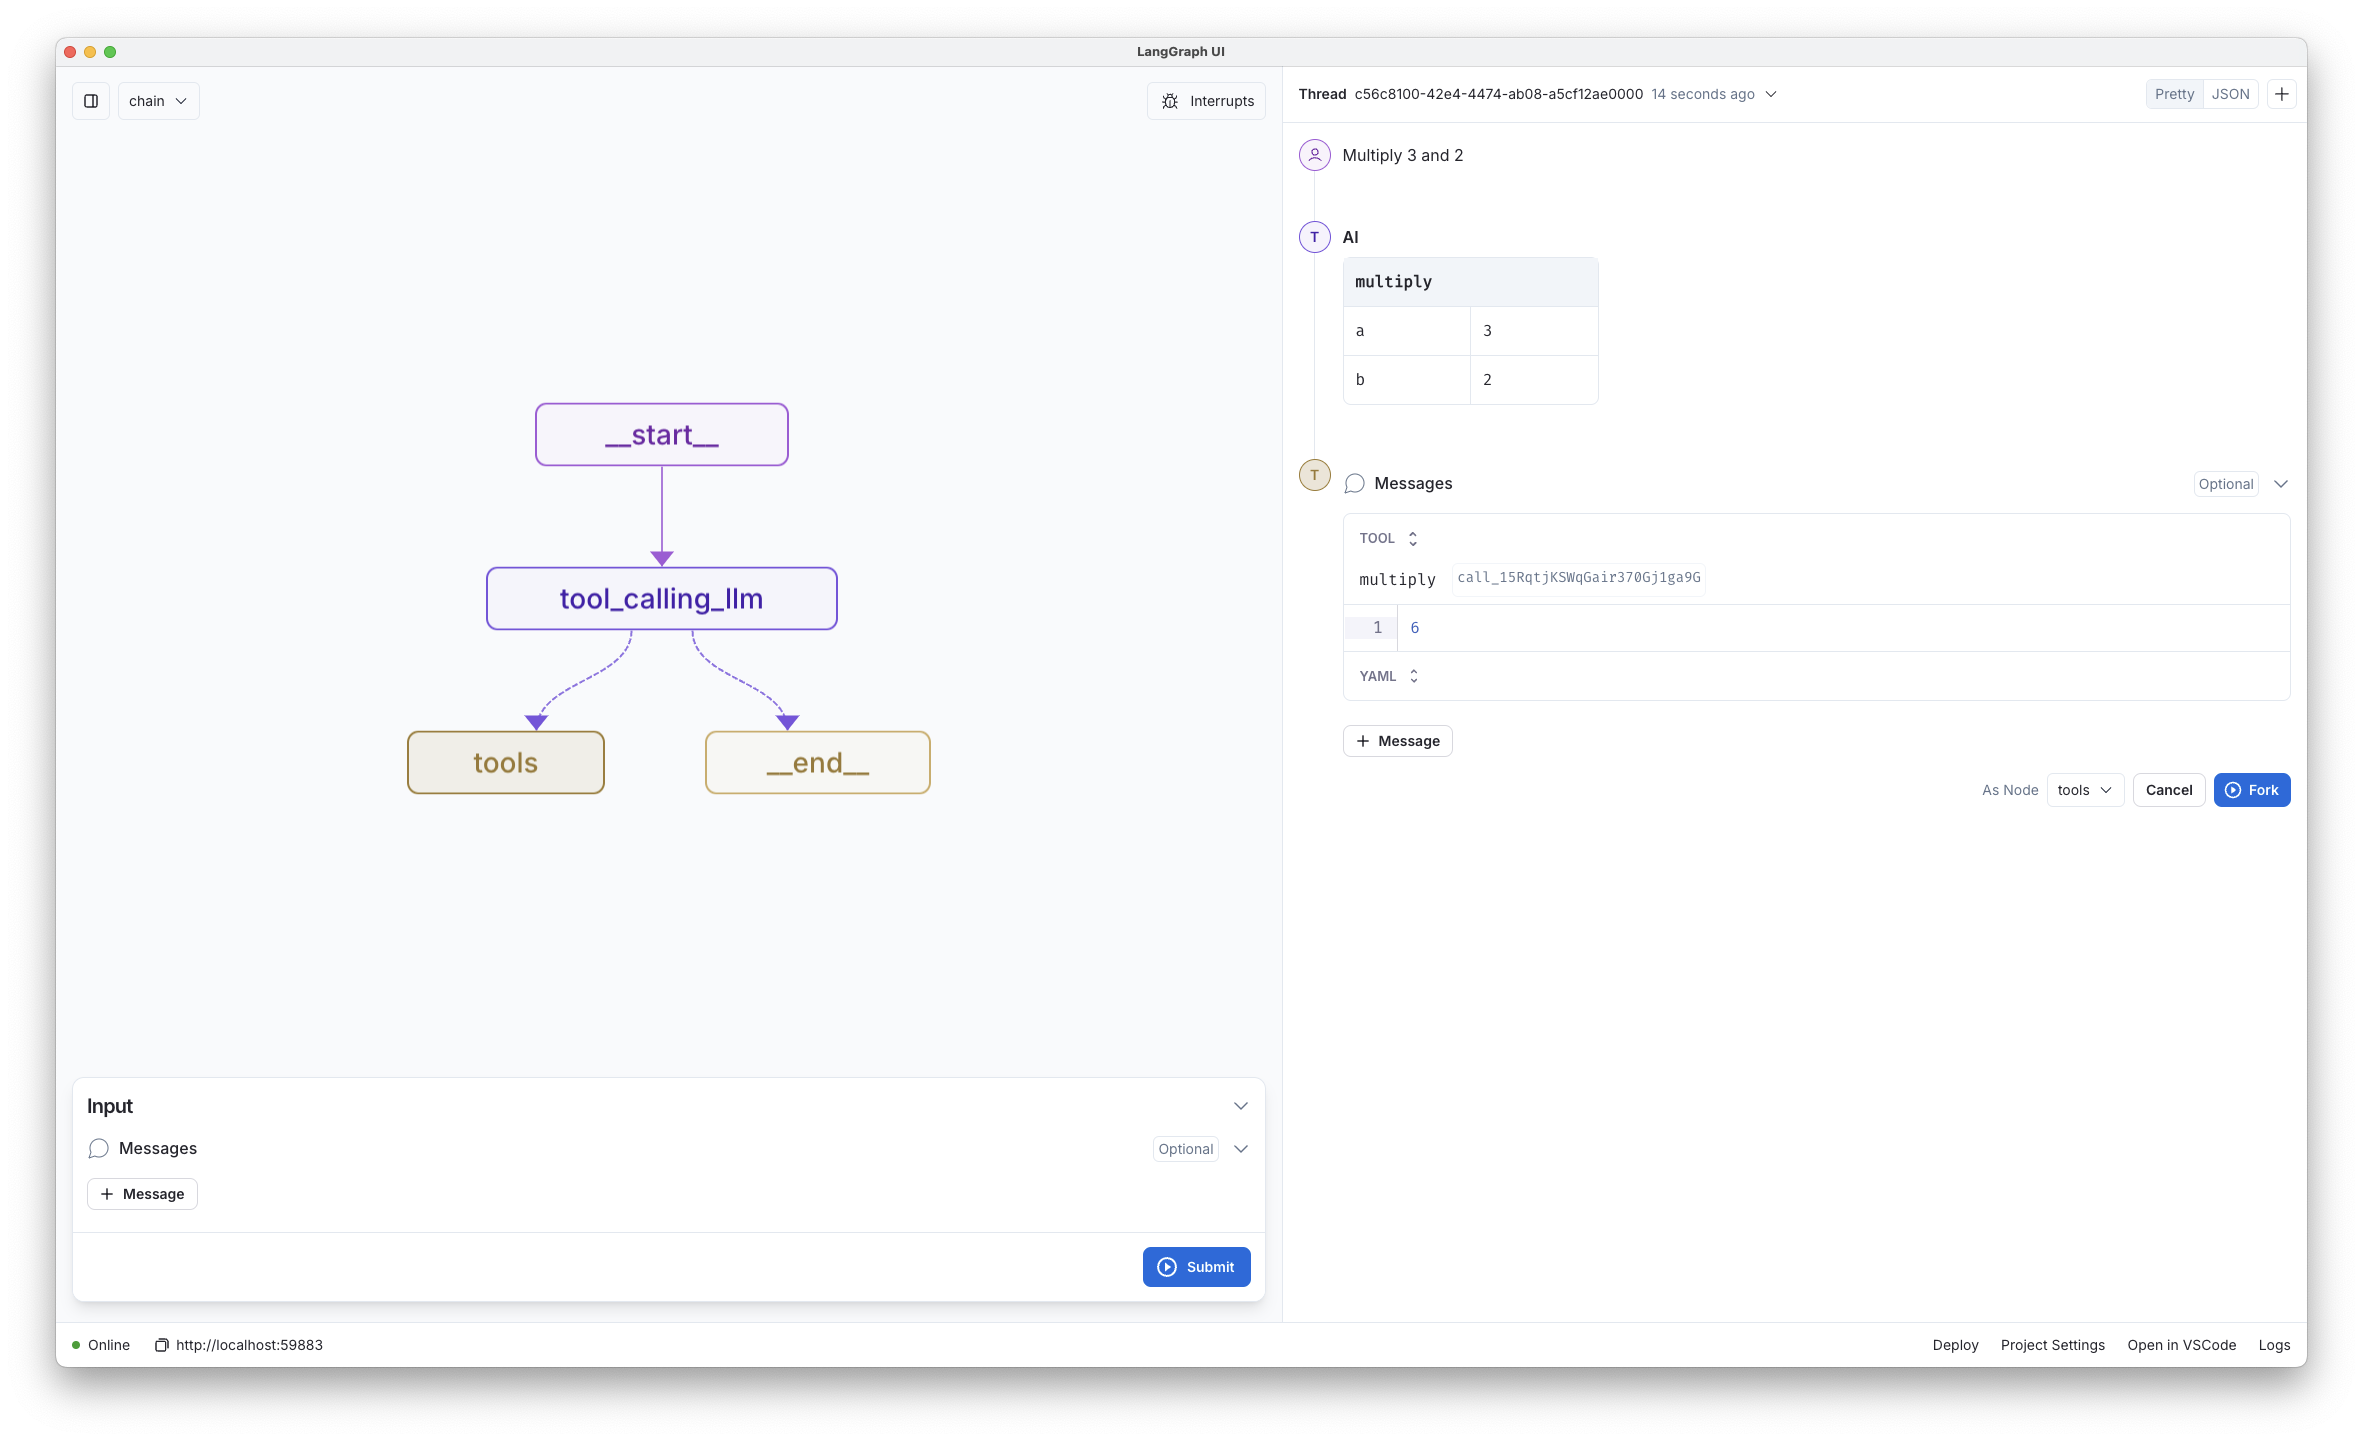

## Lesson 5: ReAct

Previously, we built a router! Now, let's bump up the complexity by building a simple autonomous agent.

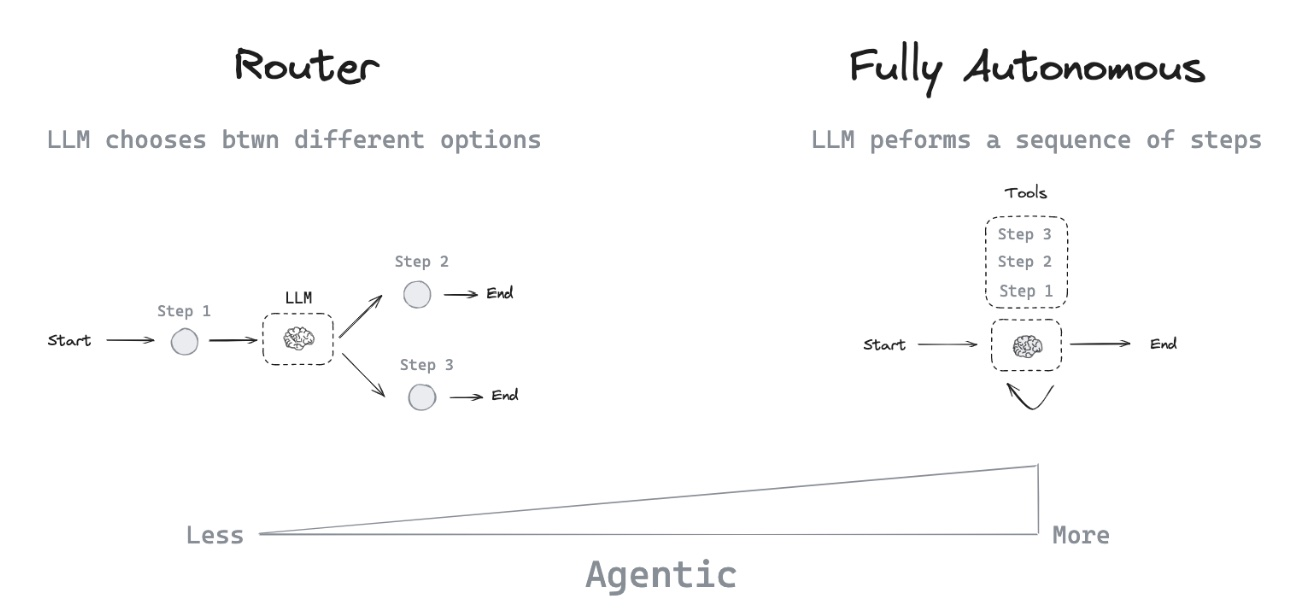

With the above concepts clear, we can combine these into a [tool calling agent](https://python.langchain.com/v0.1/docs/modules/agents/agent_types/tool_calling/)! 

The idea is simple: 

Above, we invoked our LLM, it chose to call a tool, and the tool executed, resuting a `ToolMessage`.

We just returned the raw `ToolMessage` to the user.
 
But, what if we simply pass that `ToolMessage` back to the LLM and let it either (1) call another tool or (2) respond directly.

This is the intution behind [ReAct](https://react-lm.github.io/), a general agent architecture.
  
`act` - call specific tools , `observe` - pass the tool outputs back to the LLM,  `reason` - about the tool output to decide what to do next 

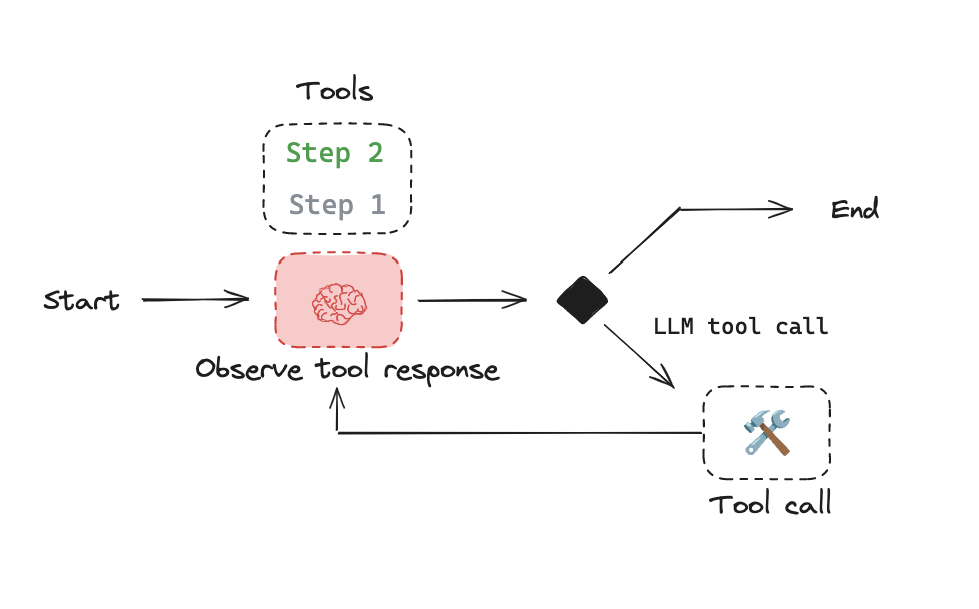

This [general purpose cognitive architecture](https://blog.langchain.dev/planning-for-agents/) can applied to any set of tools. 
 
Let's create a few new tools, `add` and `divide`.

In [122]:
# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

Let's create our LLM and prompt it with the overall desired agent behavior.

In [133]:
from typing import Annotated, List
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmatic on a set of inputs.")

# State
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# Assistant
class Assistant:
    def __init__(self, llm_with_tools):
        """
        Initialize the Assistant with llm.
        """
        self.llm_with_tools = llm_with_tools

    def __call__(self, state: MessagesState, config):
        """
        Call method to invoke
        """
        # Get messages
        messages = state['messages']
        # Invoke chat model
        result = self.llm_with_tools.invoke([sys_msg] + messages)  
        return {"messages": result}

As before, we use `MessagesState` and define a `Tools` node with our list of tools.

The `Assistant` node is just our LLM with bound tools.

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

Critically, we connect the `Tools` node back to the `Assistant`, forming a loop!

* After the "assistant" node executes, `tools_condition` checks if the LLM's output is a tool call.
* If it is a tool call, the flow is directed to the "tools" node.
* If it's not a tool call, the flow is directed to END, terminating the process.

Overall, the loop will continue so long as the LLM decides to call specific tools.

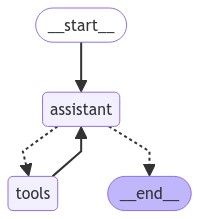

In [134]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(llm.bind_tools(tools)))
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

Now, we run!

In [135]:
messages = [HumanMessage(content="Add 3 and 4, then multiple by 2, and finally divide by 5")]
messages = react_graph.invoke({"messages": messages})
messages['messages'][-1]

AIMessage(content='The result of adding 3 and 4, then multiplying by 2, and finally dividing by 5 is 2.8.', response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 223, 'total_tokens': 252}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'stop', 'logprobs': None}, id='run-cbfc316b-3030-463b-a75d-f4a2d98b7411-0', usage_metadata={'input_tokens': 223, 'output_tokens': 29, 'total_tokens': 252})

In [138]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4, then multiple by 2, and finally divide by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_tuyJd2fReRLR9EOIvYHMtHim)
 Call ID: call_tuyJd2fReRLR9EOIvYHMtHim
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_wHunI1sQeA7a4WBni2EFy4Rd)
 Call ID: call_wHunI1sQeA7a4WBni2EFy4Rd
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_KR4L51l1cQo0AIc6WFUwwUcX)
 Call ID: call_KR4L51l1cQo0AIc6WFUwwUcX
  Args:
    a: 14
    b: 5
================================= Tool Message ====================

As shown above, we can develop and interact with our agent in Studio.

Simply load `agent.py`. 

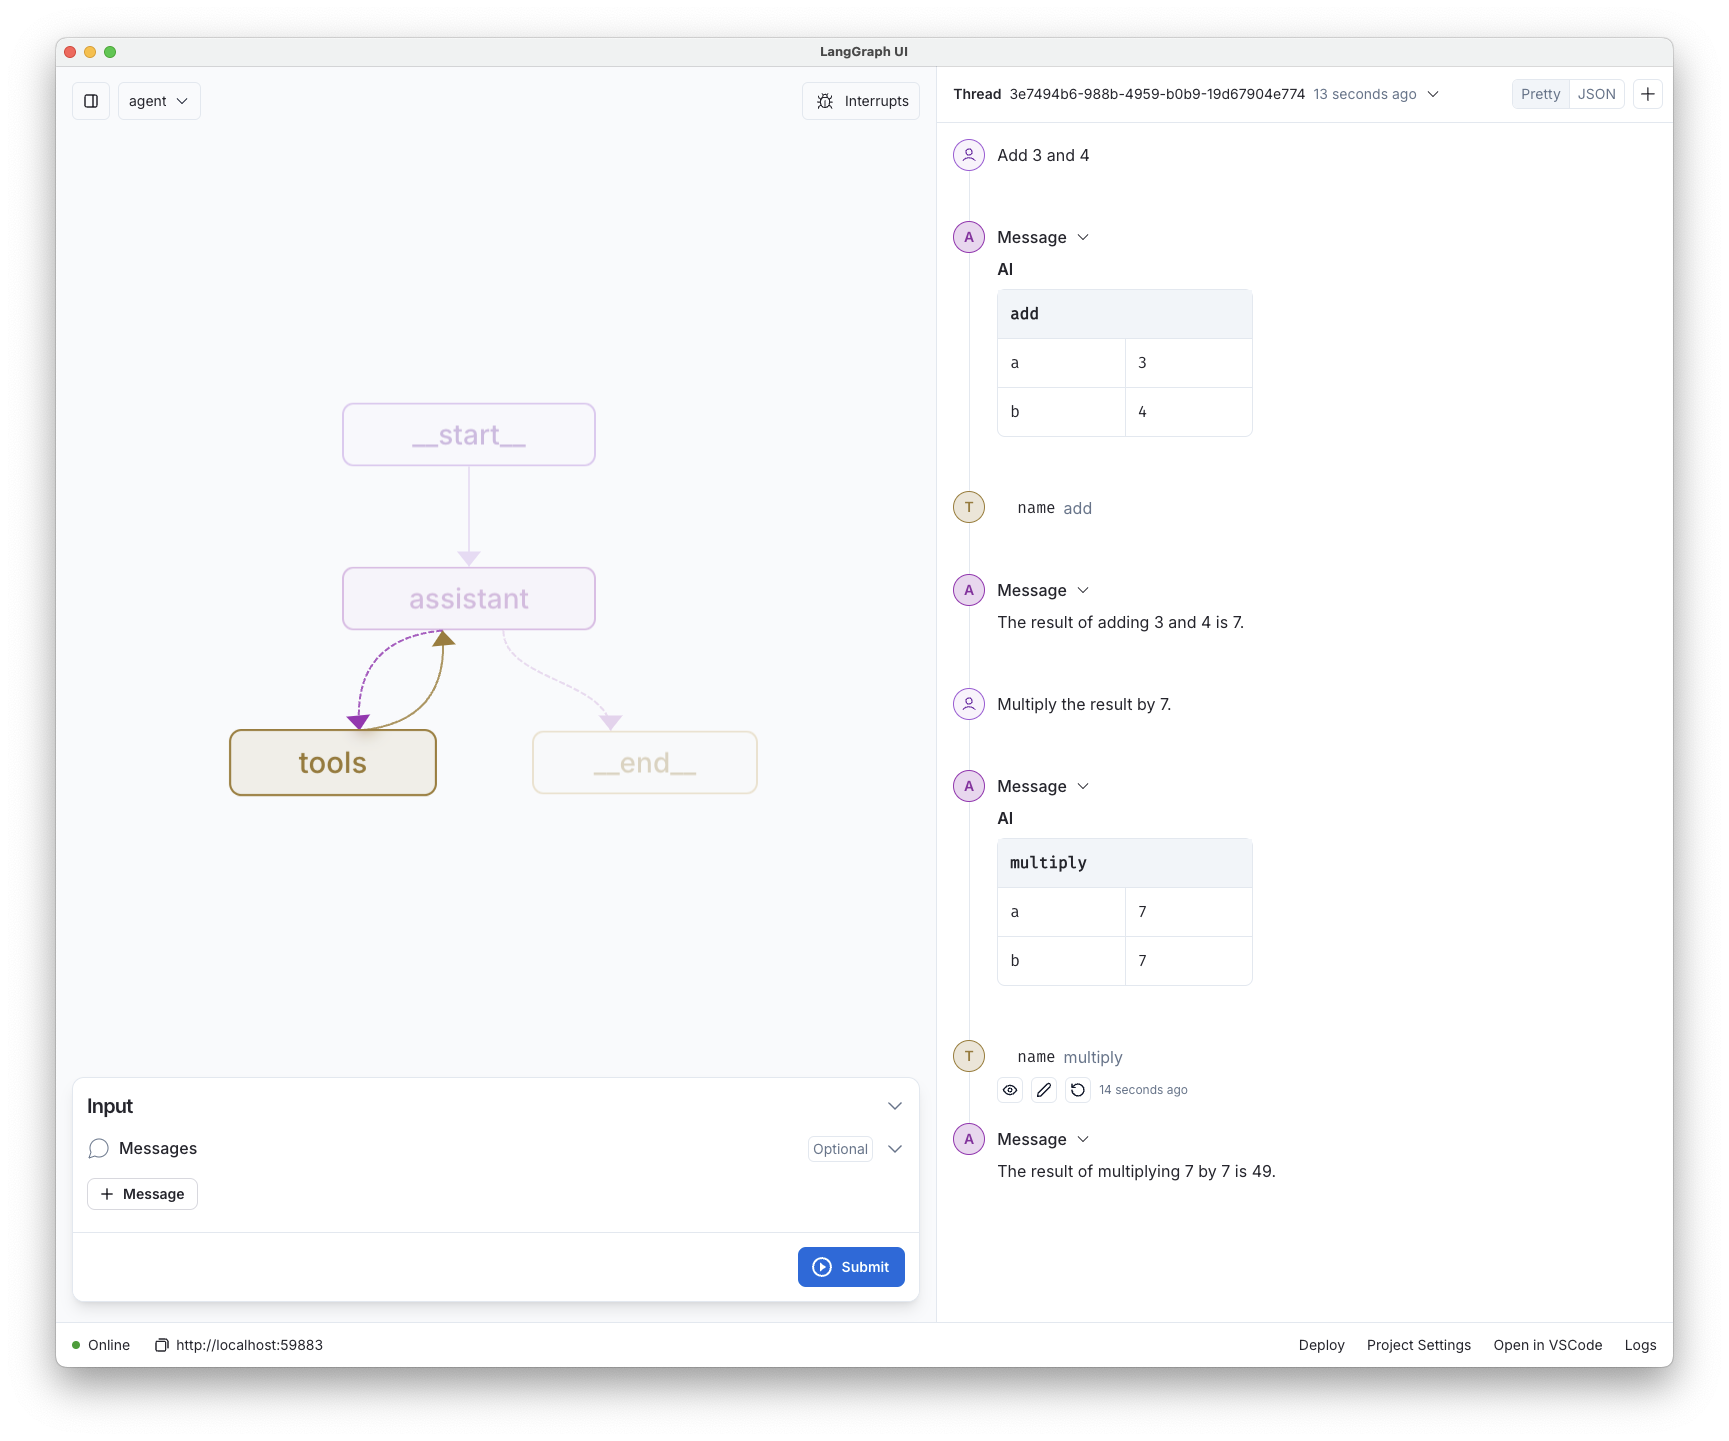

### Lesson 6: ReAct with Memory

Our agent can now use tools to answer user questions.

But it doesn't remember the context of previous interactions. 

This limits its ability to have coherent, multi-turn conversations.

We can use [memory](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 

LangGraph has support for various types of memory.

One of the easiest to work with is simply `MemorySaver`, an in-memory key-value store for your graph state.

This allows the graph to save its state after each step.

In [139]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

# Compile with memory
react_graph_memory = builder.compile(checkpointer=memory)

`configurable` sets up a configuration with a thread ID.

This thread ID will maintain a specific conversation state.

When we stream, by default we will return a `key`-`value` pair of `node`-`state`.

We can simply only stream the state by passing `stream_mode="values"`.

In [140]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Hi there! Add 3 and 4")]

# Stream
events = react_graph_memory.stream(
    {"messages": messages}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (call_tmzT1iOi5cfUS51rThCam4cC)
 Call ID: call_tmzT1iOi5cfUS51rThCam4cC
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.


The `Configuration Setup` with thread ID allows us to proceed from the previously logged state.

In [141]:
# Follow-up
messages = [HumanMessage(content="Take that output, and multiply it by 3!")]

# The config is the **second positional argument** to stream() or invoke()!
events = react_graph_memory.stream(
    {"messages": messages}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Take that output, and multiply it by 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_5Sr7okfcPusG5Hxxp755pmp1)
 Call ID: call_5Sr7okfcPusG5Hxxp755pmp1
  Args:
    a: 7
    b: 3
================================= Tool Message =================================
Name: multiply

21
================================== Ai Message ==================================

The result of multiplying 7 by 3 is 21.


In [142]:
snapshot = react_graph_memory.get_state(config)

The checkpointer allows the graph to maintain state between interactions.

The thread ID in the config ensures that multiple conversations can be managed separately.

By using the same thread ID in both interactions, the graph maintains context, allowing for coherent multi-turn conversations.

When you work with the agent in Studio, [it will automatically create a new thread](https://github.com/langchain-ai/langgraph-studio?tab=readme-ov-file#create-a-thread).

### Lesson 7: Deployment

So, we can recap! 

We've built 3 different cognitive architectures in LangGraph, and shown each in Studio:

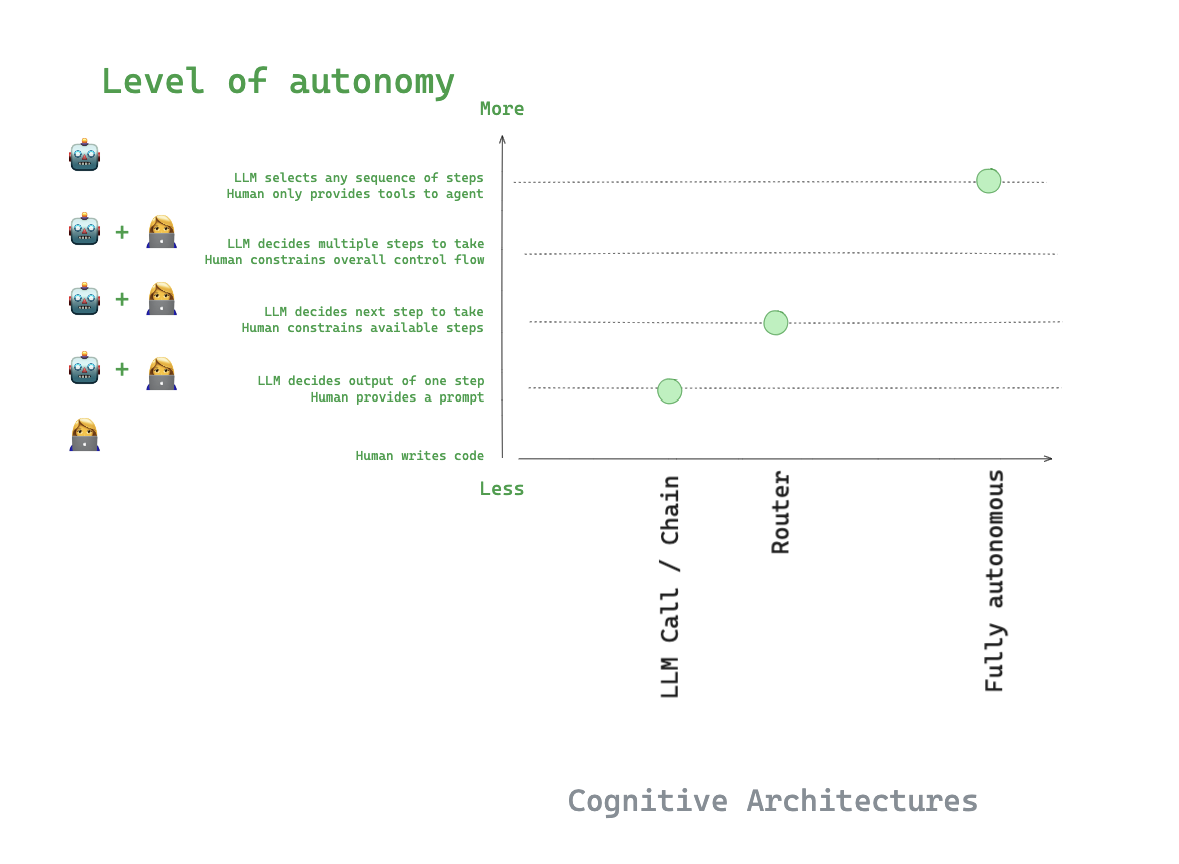

What if we wanted to deploy any of these.

We can use [LangGraph Cloud](https://langchain-ai.github.io/langgraph/cloud/) for this.

In the `assistants` directory, [we can follow these instructions](https://langchain-ai.github.io/langgraph/cloud/quick_start/#test-the-graph-build-locally):

1) Confirm LangGraph API server runs locally: 
```
langgraph up
```

2) Then, [follow instructions](https://langchain-ai.github.io/langgraph/cloud/quick_start/#deploy-from-github-with-langgraph-cloud) to set up a deployment using GitHub.